# LiH ~ oo-pUCCD ~ reduced

Determino l'initial point dei primi (8) parametri del circuito $\ket{\text{pUCCD}}$ eseguendo una prima volta VQE. 
Dopodiché le alternative sono due:
- fissare i primi parametri e ottimizzare solo i (15) $k$ orbitali
- ottimizzare ogni volta tutti i parametri

in questo programma si adotta la prima strategia. 
Il tempo di esecuzione è di circa 1 ora.

In [1]:
from functools import partial 
from time import time
import matplotlib.pyplot as plt
from pyscf import scf, fci

from subroutines import *

# Array distanze e energie
arr_distance = np.arange(0.845, 4.85, 0.25) # 14 punti 
arr_ground_energy = {
    'FCI': [],
    'pUCCD': [],
    'oo-pUCCD': []
}
arr_results = []
arr_partial_energies = []
arr_interpreted = []


In [3]:
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
freezer = FreezeCoreTransformer()

In [ ]:
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
# scelta dell'optimizer
#COBYLA(maxiter=5000, tol=0.01, rhobeg=5, disp=True)
opt = SLSQP(maxiter=1000, disp=True, tol=0.000005, ftol=0.000005)
#SLSQP(maxiter=1000, disp=True, tol=0.0005)

#for distance, puccd_starting_point in zip(arr_distance[::1], arr_puccd_ini):
for distance in arr_distance[::-1]:
    # definisco un array per contenere le energie parziali a questa distanza
    par_en = []
    
    print('- - - - - - - - - - - -', distance, '- - - - - - - - - - - -')
    # 0: FCI
    LiH = "Li 0 0 0; H 0 0 " + str(distance)
    basis = 'sto3g'
    
    ''' Integrals'''
    mol = gto.M(
        atom=LiH,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=False,
        verbose=0,
        unit='Angstrom'
    )

    frozen_orbitals = [0] # per congelare il primo orbitale
    n_frozen_orbitals = 1
    
    ''' FCI ENERGY '''
    cm  = scf.RHF(mol)
    cm.kernel() 
    fci_calc = fci.FCI(cm)
    e_FCI = fci_calc.kernel(frozen=n_frozen_orbitals)[0]
    arr_ground_energy['FCI'].append(e_FCI)
    
    print('FCI: ', e_FCI)

    ''' one/two body integrals '''
    help, one_electron_integrals, two_electron_integrals = compute_fci_energy_and_integrals(mol, frozen_orbitals)

    # 1: pUCCD
    problem = generate_problem(LiH, basis)
    problem = freezer.transform(problem)
    puccd = generate_puccd(problem)
    start_time = time()
    puccd_result = compute_puccd_optimal(puccd, problem,ini=puccd_starting_point, opt=opt) 
    eval_time = time() - start_time
    # store optimal point for next distance
    puccd_starting_point=puccd_result.optimal_point
    # and assign parameters
    assigned_puccd = puccd.assign_parameters(puccd_result.optimal_parameters)
    puccd_interpreted = problem.interpret(puccd_result)
    shift = puccd_interpreted.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    puccd_energy = puccd_interpreted.groundenergy + puccd_interpreted.nuclear_repulsion_energy + shift
    arr_ground_energy['pUCCD'].append(puccd_energy)
    
    print('pUCCD: ', puccd_energy, '| tempo: ', eval_time)
    
    # 2: oo-pUCCD
    rotations = create_orbital_rotation_list(puccd)
    excitations = convert_rotations_list(rotations)
    oo_puccd = generate_oo_puccd(assigned_puccd, problem, excitations)

    # SOLVE
    vqe_solver = VQE(Estimator(), oo_puccd, opt)
    # l'ottimizzazione parte dall'optimal value della distanza precedente
    vqe_solver.initial_point = oo_starting_point

    energy_evaluation = partial(energy_evaluation_oo, 
                                problem, 
                                one_electron_integrals,
                                two_electron_integrals,
                                vqe_solver, 
                                rotations, 
                                0,
                                par_en # ad ogni ottimizzazione viene salvata l'energia
                                )

    # setto bounds default
    bounds = [ [-np.pi,np.pi] for _ in range(oo_puccd.num_parameters) ]

    start_time = time()
    
    # minimization
    opt_result = vqe_solver.optimizer.minimize(
        fun=energy_evaluation, x0=oo_starting_point, bounds=bounds
    )
        
    eval_time = time() - start_time
    
    result = VQEResult()
    result.optimal_point = opt_result.x
    result.optimal_parameters = dict(zip(vqe_solver.ansatz.parameters, opt_result.x))
    result.optimal_value = opt_result.fun
    result.cost_function_evals = opt_result.nfev
    result.optimizer_time = eval_time
    result.eigenvalue = opt_result.fun + 0j
    
    oo_interpreted = problem.interpret(result)
    shift = oo_interpreted.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    oo_energy = oo_interpreted.groundenergy + oo_interpreted.nuclear_repulsion_energy + shift
    
    arr_ground_energy['oo-pUCCD'].append(oo_energy)
    
    print('oo-pUCCD: ', oo_energy, '| tempo: ', eval_time)
    
    # immagazzino tutto
    oo_starting_point = opt_result.x
    arr_results.append(result)
    arr_interpreted.append(oo_interpreted)
    
    print('------ OO OPTIMAL -----')
    print(oo_starting_point)
    print('------ ---------- -----')
    
    # shifto le energie parziali con nuclear repulsion
    par_en = [x + oo_interpreted.nuclear_repulsion_energy + shift for x in par_en]
    arr_partial_energies.append(par_en)

# Plot

In [5]:
method = ['FCI', 'pUCCD', 'oo-pUCCD']

arr_style = [
    ("red", "s"),    
    ("violet", "x"),  
    ("purple", "X")
]

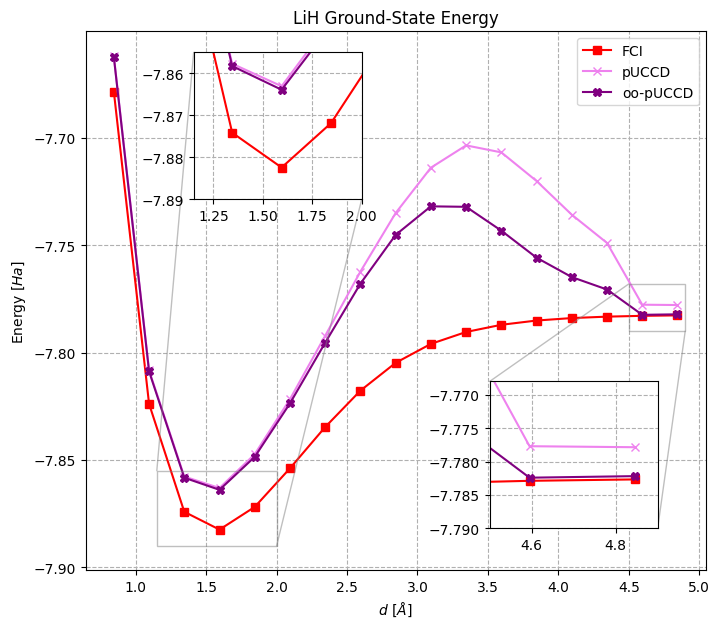

In [24]:
# Zoom sul minimo 
fig, ax = plt.subplots(figsize=[8, 7])
                       
for met, style in zip(method,arr_style):  
    plt.plot(arr_distance[::-1], arr_ground_energy[met], label=met, color=style[0], marker=style[1])

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()

# Aggiungi un inset con zoom
# [x0, y0, width, height] specifica la posizione e dimensione del riquadro
ax_inset  = plt.axes([.26, .64, .21, .21]) 

ax_inset2 = plt.axes([.63, .17, .21, .21]) 

# Imposta i limiti di zoom
ax_inset.axis(xmin=1.15,xmax=2.)
ax_inset.axis(ymin=-7.89,ymax=-7.855)

ax_inset2.axis(xmin=4.5,xmax=4.9)
ax_inset2.axis(ymin=-7.79,ymax=-7.768)

for met, style in zip(method,arr_style):  
    ax_inset.plot(arr_distance[::-1], arr_ground_energy[met], label=met, color=style[0], marker=style[1])
    ax_inset2.plot(arr_distance[::-1], arr_ground_energy[met], label=met, color=style[0], marker=style[1])


# Aggiungi griglia nel grafico piccolo
ax_inset.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset)

# Aggiungi griglia nel grafico piccolo
ax_inset2.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset2)

plt.show()

# Energie

In [ ]:
print('GROUND')
for met in method:
    print(met + ': ', arr_ground_energy[met][-4])
    
print('DISSOCIAZIONE')
for met in method:
    print(met + ': ', arr_ground_energy[met][0])

GROUND
FCI:  -7.882401932290221
pUCCD:  -7.8630450741090305
oo-pUCCD:  -7.8638791910858306
DISSOCIAZIONE
FCI:  -7.782662470038797
pUCCD:  -7.777844000147944
oo-pUCCD:  -7.782171069702882


# Circuito oo

In [8]:
puccd = puccd.decompose().decompose()

print('Caratteristiche circuito pUCCD')
print('Num parameters: ', puccd.num_parameters)
print('Depth: ', puccd.depth())
print('Gates:')
print(puccd.count_ops())

Caratteristiche circuito pUCCD
Num parameters:  4
Depth:  511
Gates:
OrderedDict({'cx': 384, 'h': 256, 'sdg': 64, 's': 64, 'rz': 32, 'u3': 2})


In [9]:
oo_puccd = oo_puccd.decompose().decompose()

print('Caratteristiche circuito oo-pUCCD')
print('Num parameters: ', oo_puccd.num_parameters)
print('Depth: ', oo_puccd.depth())
print('Gates:')
print(oo_puccd.count_ops())

Caratteristiche circuito oo-pUCCD
Num parameters:  10
Depth:  155
Gates:
OrderedDict({'h': 80, 'cx': 80, 'sdg': 20, 'rz': 20, 's': 20, 'PauliEvolution': 4, 'x': 2})


# Grafico convergenza

Progressione ottimizzazione nel punto di minimo (punto 4)

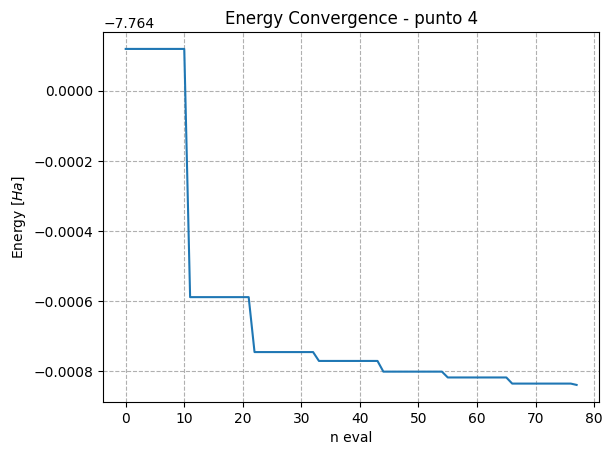

In [10]:
plt.plot(range(len(arr_partial_energies[3])), arr_partial_energies[3])

plt.title("Energy Convergence - punto 4")
plt.xlabel(r"n eval")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
#plt.legend()
plt.show()